In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset as HFDataset
import optuna
import warnings


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    """Fungsi untuk membuat dan menampilkan confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'{title}.png')
    plt.show()


# --- 1. Memuat Data dan EDA ---

--- 1. Memuat Data dan Exploratory Data Analysis (EDA) ---
File CSV berhasil dimuat.

Visualisasi EDA disimpan sebagai 'label_distribution.png'


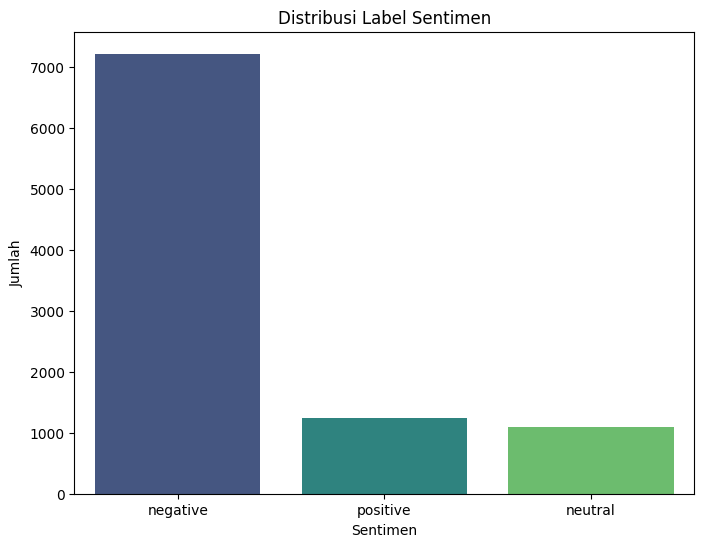

In [6]:
print("--- 1. Memuat Data dan Exploratory Data Analysis (EDA) ---")
try:
    df = pd.read_csv('/content/drive/MyDrive/SKRIPSI CODE ETC/Datasets/merged_train_ready_full_2.csv')
    if 'label' in df.columns and 'final_label' not in df.columns:
        df.rename(columns={'label': 'final_label'}, inplace=True)
    print("File CSV berhasil dimuat.")
except FileNotFoundError:
    print("Error: File tidak ditemukan. Pastikan path file CSV sudah benar.")
    exit()

plt.figure(figsize=(8, 6))
sns.countplot(x='final_label', data=df, order=df['final_label'].value_counts().index, palette='viridis')
plt.title('Distribusi Label Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.savefig('label_distribution.png')
print("\nVisualisasi EDA disimpan sebagai 'label_distribution.png'")
plt.show()

# --- 2. Persiapan Data ---

In [7]:
print("\n--- 2. Persiapan Data ---")
label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
df['final_label_encoded'] = df['final_label'].map(label_map)
df.dropna(subset=['final_label_encoded'], inplace=True)
df['final_label_encoded'] = df['final_label_encoded'].astype(int)

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['final_label_encoded']
)
y_train = train_df['final_label_encoded']
y_test = test_df['final_label_encoded']

print(f"Ukuran data latih: {train_df.shape[0]}")
print(f"Ukuran data uji: {test_df.shape[0]}")

final_results = {}



--- 2. Persiapan Data ---
Ukuran data latih: 7636
Ukuran data uji: 1910


# --- 3. Skenario 1: SVM & Naive Bayes ---


--- 3. Skenario 1: SVM & Naive Bayes (Baseline) ---

--- HASIL MODEL SVM (BASELINE) ---
Akurasi SVM (Baseline): 0.8524
Laporan Klasifikasi SVM (Baseline):
              precision    recall  f1-score   support

    positive       0.85      0.99      0.91      1445
     neutral       0.92      0.36      0.52       217
    negative       0.86      0.50      0.64       248

    accuracy                           0.85      1910
   macro avg       0.88      0.62      0.69      1910
weighted avg       0.86      0.85      0.83      1910



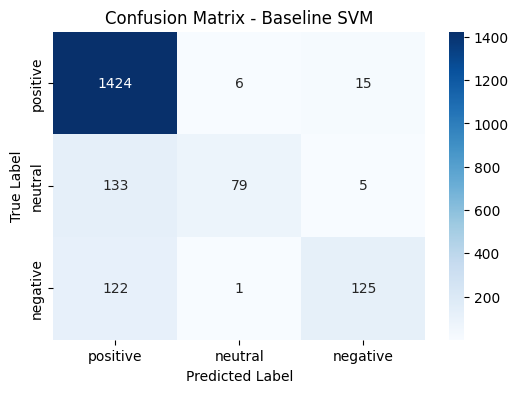


--- HASIL MODEL NAIVE BAYES (BASELINE) ---
Akurasi Naive Bayes (Baseline): 0.7644
Laporan Klasifikasi Naive Bayes (Baseline):
              precision    recall  f1-score   support

    positive       0.76      1.00      0.87      1445
     neutral       0.67      0.01      0.02       217
    negative       0.83      0.06      0.11       248

    accuracy                           0.76      1910
   macro avg       0.75      0.36      0.33      1910
weighted avg       0.76      0.76      0.67      1910



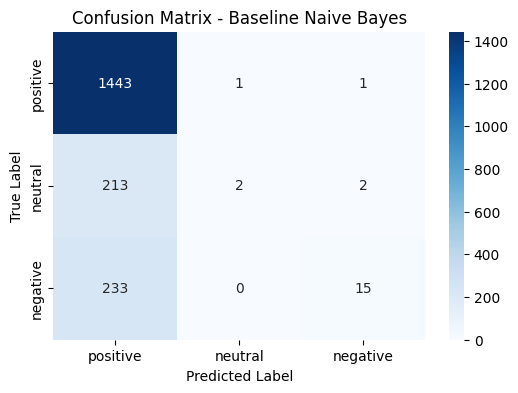


--- 3. Skenario 1: SVM & Naive Bayes (Optimized) ---

Memulai tuning hyperparameter untuk SVM...

--- HASIL MODEL SVM (OPTIMIZED) ---
Parameter Terbaik: {'C': 10, 'kernel': 'rbf'}
Akurasi SVM: 0.8806
Laporan Klasifikasi SVM:
              precision    recall  f1-score   support

    positive       0.89      0.97      0.93      1445
     neutral       0.82      0.54      0.65       217
    negative       0.85      0.67      0.75       248

    accuracy                           0.88      1910
   macro avg       0.85      0.73      0.78      1910
weighted avg       0.88      0.88      0.87      1910



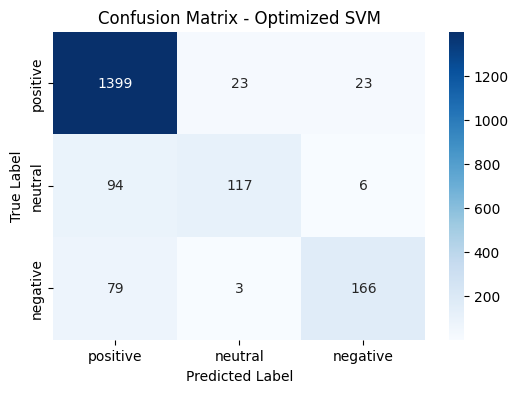


Memulai tuning hyperparameter untuk Naive Bayes...

--- HASIL MODEL NAIVE BAYES (OPTIMIZED) ---
Parameter Terbaik: {'alpha': 0.1}
Akurasi Naive Bayes: 0.8073
Laporan Klasifikasi Naive Bayes:
              precision    recall  f1-score   support

    positive       0.81      0.98      0.89      1445
     neutral       0.73      0.24      0.36       217
    negative       0.76      0.33      0.46       248

    accuracy                           0.81      1910
   macro avg       0.77      0.51      0.57      1910
weighted avg       0.80      0.81      0.77      1910



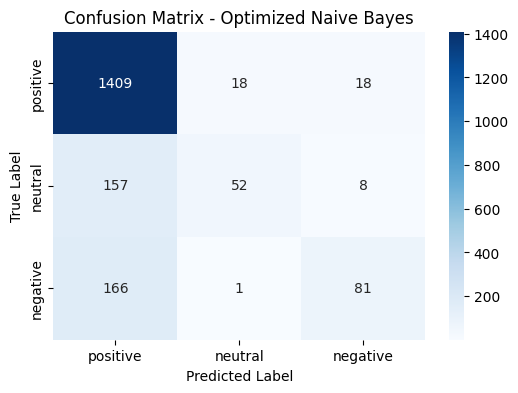

In [8]:
print("\n--- 3. Skenario 1: SVM & Naive Bayes (Baseline) ---")
X_train_classic = train_df['text_lexicon'].astype(str)
X_test_classic = test_df['text_lexicon'].astype(str)

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_classic)
X_test_tfidf = tfidf_vectorizer.transform(X_test_classic)

# Baseline SVM
print("\n--- HASIL MODEL SVM (BASELINE) ---")
svm_base = SVC(random_state=42)
svm_base.fit(X_train_tfidf, y_train)
y_pred_svm_base = svm_base.predict(X_test_tfidf)
final_results['Baseline SVM'] = classification_report(y_test, y_pred_svm_base, output_dict=True)['weighted avg']
print(f"Akurasi SVM (Baseline): {accuracy_score(y_test, y_pred_svm_base):.4f}")
print("Laporan Klasifikasi SVM (Baseline):")
print(classification_report(y_test, y_pred_svm_base, target_names=label_map.keys()))
plot_confusion_matrix(y_test, y_pred_svm_base, label_map.keys(), "Confusion Matrix - Baseline SVM")


# Baseline Naive Bayes
print("\n--- HASIL MODEL NAIVE BAYES (BASELINE) ---")
nb_base = MultinomialNB()
nb_base.fit(X_train_tfidf, y_train)
y_pred_nb_base = nb_base.predict(X_test_tfidf)
final_results['Baseline Naive Bayes'] = classification_report(y_test, y_pred_nb_base, output_dict=True)['weighted avg']
print(f"Akurasi Naive Bayes (Baseline): {accuracy_score(y_test, y_pred_nb_base):.4f}")
print("Laporan Klasifikasi Naive Bayes (Baseline):")
print(classification_report(y_test, y_pred_nb_base, target_names=label_map.keys()))
plot_confusion_matrix(y_test, y_pred_nb_base, label_map.keys(), "Confusion Matrix - Baseline Naive Bayes")


print("\n--- 3. Skenario 1: SVM & Naive Bayes (Optimized) ---")
# Tuning dan Evaluasi SVM
print("\nMemulai tuning hyperparameter untuk SVM...")
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_svm = GridSearchCV(SVC(random_state=42, class_weight='balanced'), param_grid_svm, refit=True, verbose=0, cv=3)
grid_svm.fit(X_train_tfidf, y_train)
y_pred_svm = grid_svm.best_estimator_.predict(X_test_tfidf)
final_results['Optimized SVM'] = classification_report(y_test, y_pred_svm, output_dict=True)['weighted avg']

print("\n--- HASIL MODEL SVM (OPTIMIZED) ---")
print(f"Parameter Terbaik: {grid_svm.best_params_}")
print(f"Akurasi SVM: {accuracy_score(y_test, y_pred_svm):.4f}")
print("Laporan Klasifikasi SVM:")
print(classification_report(y_test, y_pred_svm, target_names=label_map.keys()))
plot_confusion_matrix(y_test, y_pred_svm, label_map.keys(), "Confusion Matrix - Optimized SVM")

# Tuning dan Evaluasi Naive Bayes
print("\nMemulai tuning hyperparameter untuk Naive Bayes...")
param_grid_nb = {'alpha': [0.01, 0.1, 0.5, 1.0]}
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, refit=True, verbose=0, cv=3)
grid_nb.fit(X_train_tfidf, y_train)
y_pred_nb = grid_nb.best_estimator_.predict(X_test_tfidf)
final_results['Optimized Naive Bayes'] = classification_report(y_test, y_pred_nb, output_dict=True)['weighted avg']

print("\n--- HASIL MODEL NAIVE BAYES (OPTIMIZED) ---")
print(f"Parameter Terbaik: {grid_nb.best_params_}")
print(f"Akurasi Naive Bayes: {accuracy_score(y_test, y_pred_nb):.4f}")
print("Laporan Klasifikasi Naive Bayes:")
print(classification_report(y_test, y_pred_nb, target_names=label_map.keys()))
plot_confusion_matrix(y_test, y_pred_nb, label_map.keys(), "Confusion Matrix - Optimized Naive Bayes")

# --- Menghitung Class Weight untuk Model Deep Learning ---

In [9]:
print("\nMenghitung Class Weight untuk Model Deep Learning...")
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print(f"Bobot Kelas yang dihitung: {class_weights_tensor}")


Menghitung Class Weight untuk Model Deep Learning...
Bobot Kelas yang dihitung: tensor([0.4408, 2.9257, 2.5684])


# --- 4. Skenario 2: BiLSTM ---



--- 4. Skenario 2: BiLSTM (Baseline) ---

--- HASIL MODEL BiLSTM (BASELINE) ---
Akurasi BiLSTM (Baseline): 0.7984
Laporan Klasifikasi BiLSTM (Baseline):
              precision    recall  f1-score   support

    positive       0.92      0.83      0.87      1445
     neutral       0.56      0.65      0.60       217
    negative       0.53      0.75      0.62       248

    accuracy                           0.80      1910
   macro avg       0.67      0.74      0.70      1910
weighted avg       0.83      0.80      0.81      1910



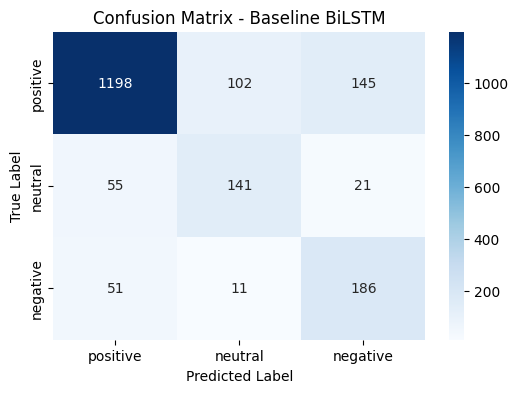

[I 2025-10-14 09:56:06,119] A new study created in memory with name: no-name-a435572a-ae2c-4664-b8d9-bc3d032dbe01




--- 4. Skenario 2: BiLSTM (Optimized) ---

Memulai tuning hyperparameter untuk BiLSTM dengan Optuna...


[I 2025-10-14 09:56:15,285] Trial 0 finished with value: 0.8230366492146597 and parameters: {'emb_dim': 300, 'hid_dim': 128, 'n_layers': 2, 'dropout': 0.3190714402545459, 'lr': 0.001207821101601563}. Best is trial 0 with value: 0.8230366492146597.
[I 2025-10-14 09:56:24,531] Trial 1 finished with value: 0.487434554973822 and parameters: {'emb_dim': 300, 'hid_dim': 128, 'n_layers': 2, 'dropout': 0.5589872935655369, 'lr': 0.00014297711788875355}. Best is trial 0 with value: 0.8230366492146597.
[I 2025-10-14 09:56:48,995] Trial 2 finished with value: 0.7471204188481675 and parameters: {'emb_dim': 200, 'hid_dim': 256, 'n_layers': 2, 'dropout': 0.41023057176039135, 'lr': 0.0012062967727642265}. Best is trial 0 with value: 0.8230366492146597.
[I 2025-10-14 09:57:18,135] Trial 3 finished with value: 0.8366492146596859 and parameters: {'emb_dim': 200, 'hid_dim': 256, 'n_layers': 2, 'dropout': 0.4963174658881654, 'lr': 0.004638805341154061}. Best is trial 3 with value: 0.8366492146596859.
[I 20


Melatih model final BiLSTM dengan parameter terbaik...

--- HASIL MODEL BiLSTM (OPTIMIZED) ---
Parameter Terbaik: {'emb_dim': 200, 'hid_dim': 256, 'n_layers': 2, 'dropout': 0.4963174658881654, 'lr': 0.004638805341154061}
Akurasi BiLSTM: 0.8660
Laporan Klasifikasi BiLSTM:
              precision    recall  f1-score   support

    positive       0.92      0.92      0.92      1445
     neutral       0.70      0.63      0.66       217
    negative       0.71      0.75      0.73       248

    accuracy                           0.87      1910
   macro avg       0.77      0.77      0.77      1910
weighted avg       0.87      0.87      0.87      1910



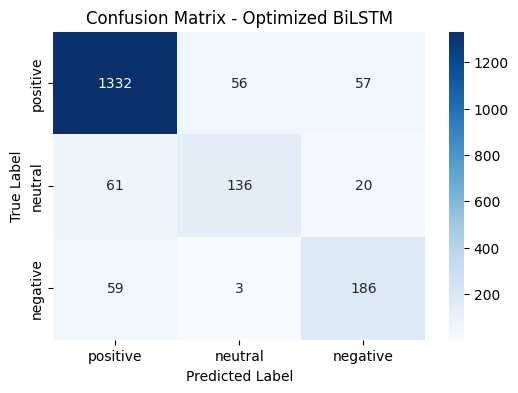

In [10]:
print("\n\n--- 4. Skenario 2: BiLSTM (Baseline) ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights_tensor = class_weights_tensor.to(device)

X_train_dl = train_df['text_clean'].astype(str)
X_test_dl = test_df['text_clean'].astype(str)
word_counts = Counter(word for text in X_train_dl for word in text.split())
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
word_to_idx = {word: i + 2 for i, word in enumerate(vocab)}; word_to_idx['<PAD>'] = 0; word_to_idx['<UNK>'] = 1

def text_to_sequence(text, w2i): return [w2i.get(word, 1) for word in text.split()]
X_train_seq = [text_to_sequence(text, word_to_idx) for text in X_train_dl]
X_test_seq = [text_to_sequence(text, word_to_idx) for text in X_test_dl]

def pad_sequences(sequences, max_len=100):
    padded = np.zeros((len(sequences), max_len), dtype=np.int64)
    for i, seq in enumerate(sequences):
        seq_len = len(seq)
        if seq_len > 0: padded[i, :min(seq_len, max_len)] = seq[:max_len]
    return padded

X_train_pad = pad_sequences(X_train_seq); X_test_pad = pad_sequences(X_test_seq)

class TorchSentimentDataset(Dataset):
    def __init__(self, X, y): self.X = torch.from_numpy(X).long(); self.y = torch.from_numpy(y).long()
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_dataset_lstm = TorchSentimentDataset(X_train_pad, y_train.to_numpy())
val_dataset_lstm = TorchSentimentDataset(X_test_pad, y_test.to_numpy())

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, out_dim, n_layers, dropout):
        super().__init__(); self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0); self.lstm = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, bidirectional=True, batch_first=True, dropout=dropout); self.fc = nn.Linear(hid_dim * 2, out_dim); self.dropout = nn.Dropout(dropout)
    def forward(self, text):
        embedded = self.dropout(self.embedding(text)); outputs, (hidden, cell) = self.lstm(embedded); hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)); return self.fc(hidden)

# Baseline BiLSTM
print("\n--- HASIL MODEL BiLSTM (BASELINE) ---")
bilstm_base = BiLSTMClassifier(len(word_to_idx), 100, 128, 3, 1, 0.5).to(device)
optimizer_base = torch.optim.Adam(bilstm_base.parameters())
criterion_base = nn.CrossEntropyLoss(weight=class_weights_tensor).to(device)
train_loader_base = DataLoader(train_dataset_lstm, batch_size=64, shuffle=True)

for epoch in range(15):
    bilstm_base.train()
    for data, target in train_loader_base:
        data, target = data.to(device), target.to(device); optimizer_base.zero_grad(); output = bilstm_base(data); loss = criterion_base(output, target); loss.backward(); optimizer_base.step()

bilstm_base.eval(); all_preds_bilstm_base = []
test_loader_base = DataLoader(val_dataset_lstm, batch_size=64)
with torch.no_grad():
    for data, _ in test_loader_base:
        outputs = bilstm_base(data.to(device)); _, predicted = torch.max(outputs.data, 1); all_preds_bilstm_base.extend(predicted.cpu().numpy())
y_pred_bilstm_base = np.array(all_preds_bilstm_base)
final_results['Baseline BiLSTM'] = classification_report(y_test, y_pred_bilstm_base, output_dict=True)['weighted avg']
print(f"Akurasi BiLSTM (Baseline): {accuracy_score(y_test, y_pred_bilstm_base):.4f}")
print("Laporan Klasifikasi BiLSTM (Baseline):")
print(classification_report(y_test, y_pred_bilstm_base, target_names=label_map.keys()))
plot_confusion_matrix(y_test, y_pred_bilstm_base, label_map.keys(), "Confusion Matrix - Baseline BiLSTM")


print("\n\n--- 4. Skenario 2: BiLSTM (Optimized) ---")
def objective_bilstm(trial):
    emb_dim = trial.suggest_categorical("emb_dim", [100, 200, 300])
    hid_dim = trial.suggest_categorical("hid_dim", [128, 256])
    n_layers = trial.suggest_int("n_layers", 1, 2)
    dropout = trial.suggest_float("dropout", 0.3, 0.6)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    model = BiLSTMClassifier(len(word_to_idx), emb_dim, hid_dim, 3, n_layers, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor).to(device)
    train_loader = DataLoader(train_dataset_lstm, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset_lstm, batch_size=64)

    model.train()
    for epoch in range(5):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device); optimizer.zero_grad(); output = model(data); loss = criterion(output, target); loss.backward(); optimizer.step()

    model.eval(); correct = 0; total = 0
    with torch.no_grad():
        for data, target in val_loader:
            outputs = model(data.to(device)); _, predicted = torch.max(outputs.data, 1); total += target.size(0); correct += (predicted == target.to(device)).sum().item()
    return correct / total

print("\nMemulai tuning hyperparameter untuk BiLSTM dengan Optuna...")
study_bilstm = optuna.create_study(direction="maximize")
study_bilstm.optimize(objective_bilstm, n_trials=10)
best_params_bilstm = study_bilstm.best_params
model_params_bilstm = {k: v for k, v in best_params_bilstm.items() if k != 'lr'}

print("\nMelatih model final BiLSTM dengan parameter terbaik...")
final_bilstm_model = BiLSTMClassifier(vocab_size=len(word_to_idx), out_dim=3, **model_params_bilstm).to(device)
optimizer = torch.optim.Adam(final_bilstm_model.parameters(), lr=best_params_bilstm['lr'])
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor).to(device)
train_loader_final = DataLoader(train_dataset_lstm, batch_size=64, shuffle=True)

for epoch in range(15):
    final_bilstm_model.train()
    for data, target in train_loader_final:
        data, target = data.to(device), target.to(device); optimizer.zero_grad(); output = final_bilstm_model(data); loss = criterion(output, target); loss.backward(); optimizer.step()

# Evaluasi BiLSTM
final_bilstm_model.eval(); all_preds_bilstm = []
test_loader_final = DataLoader(val_dataset_lstm, batch_size=64)
with torch.no_grad():
    for data, _ in test_loader_final:
        outputs = final_bilstm_model(data.to(device)); _, predicted = torch.max(outputs.data, 1); all_preds_bilstm.extend(predicted.cpu().numpy())
y_pred_bilstm = np.array(all_preds_bilstm)
final_results['Optimized BiLSTM'] = classification_report(y_test, y_pred_bilstm, output_dict=True)['weighted avg']

print("\n--- HASIL MODEL BiLSTM (OPTIMIZED) ---")
print(f"Parameter Terbaik: {best_params_bilstm}")
print(f"Akurasi BiLSTM: {accuracy_score(y_test, y_pred_bilstm):.4f}")
print("Laporan Klasifikasi BiLSTM:")
print(classification_report(y_test, y_pred_bilstm, target_names=label_map.keys()))
plot_confusion_matrix(y_test, y_pred_bilstm, label_map.keys(), "Confusion Matrix - Optimized BiLSTM")

# --- 5. Skenario 3: IndoBERT ---



--- 5. Skenario 3: IndoBERT (Baseline) ---


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/7636 [00:00<?, ? examples/s]

Map:   0%|          | 0/1910 [00:00<?, ? examples/s]


--- HASIL MODEL IndoBERT (BASELINE) ---


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Step,Training Loss
100,0.939300
200,0.798900
300,0.710800
400,0.715000
500,0.726900
600,0.587800
700,0.574400
800,0.611700
900,0.544900


Akurasi IndoBERT (Baseline): 0.8958
Laporan Klasifikasi IndoBERT (Baseline):
              precision    recall  f1-score   support

    positive       0.95      0.92      0.94      1445
     neutral       0.77      0.71      0.74       217
    negative       0.72      0.89      0.79       248

    accuracy                           0.90      1910
   macro avg       0.81      0.84      0.82      1910
weighted avg       0.90      0.90      0.90      1910



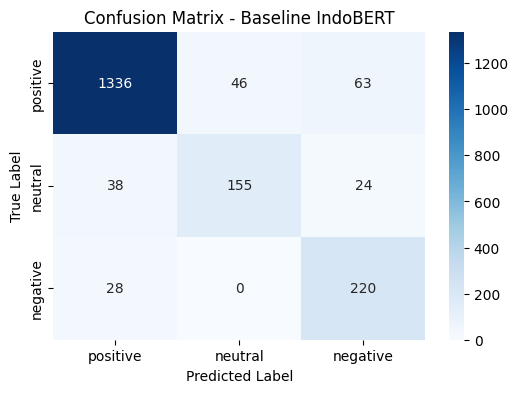

[I 2025-10-14 10:04:22,343] A new study created in memory with name: no-name-78190856-a558-4c96-a599-8692cb7f50e5




--- 5. Skenario 3: IndoBERT (Optimized) ---

Memulai tuning hyperparameter untuk IndoBERT dengan Optuna...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.661, 'grad_norm': 75.84524536132812, 'learning_rate': 1.4827104101976955e-05, 'epoch': 0.5235602094240838}
{'eval_loss': 0.4598161280155182, 'eval_accuracy': 0.9141361256544502, 'eval_runtime': 13.5004, 'eval_samples_per_second': 141.477, 'eval_steps_per_second': 17.703, 'epoch': 1.0}
{'loss': 0.5204, 'grad_norm': 0.17912444472312927, 'learning_rate': 1.169373468059552e-05, 'epoch': 1.0471204188481675}
{'loss': 0.2891, 'grad_norm': 0.06974922865629196, 'learning_rate': 8.560365259214084e-06, 'epoch': 1.5706806282722514}
{'eval_loss': 0.6152456998825073, 'eval_accuracy': 0.9413612565445026, 'eval_runtime': 13.4795, 'eval_samples_per_second': 141.697, 'eval_steps_per_second': 17.731, 'epoch': 2.0}
{'loss': 0.2337, 'grad_norm': 3.7090179920196533, 'learning_rate': 5.426995837832648e-06, 'epoch': 2.094240837696335}
{'loss': 0.0671, 'grad_norm': 0.0070846048183739185, 'learning_rate': 2.2936264164512115e-06, 'epoch': 2.6178010471204187}
{'eval_loss': 0.4967682957649231, 'eval_acc

[I 2025-10-14 10:14:15,652] Trial 0 finished with value: 0.9450261780104712 and parameters: {'learning_rate': 1.795420678451563e-05, 'num_train_epochs': 3, 'weight_decay': 0.025518006070242454}. Best is trial 0 with value: 0.9450261780104712.


{'eval_loss': 0.4967682957649231, 'eval_accuracy': 0.9450261780104712, 'eval_runtime': 13.4562, 'eval_samples_per_second': 141.942, 'eval_steps_per_second': 17.761, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6583, 'grad_norm': 24.430091857910156, 'learning_rate': 1.344164522364808e-05, 'epoch': 0.5235602094240838}
{'eval_loss': 0.3963681161403656, 'eval_accuracy': 0.9109947643979057, 'eval_runtime': 13.5008, 'eval_samples_per_second': 141.473, 'eval_steps_per_second': 17.703, 'epoch': 1.0}
{'loss': 0.5117, 'grad_norm': 0.1430513709783554, 'learning_rate': 1.0601060856858544e-05, 'epoch': 1.0471204188481675}
{'loss': 0.2837, 'grad_norm': 0.248936727643013, 'learning_rate': 7.76047649006901e-06, 'epoch': 1.5706806282722514}
{'eval_loss': 0.5856626629829407, 'eval_accuracy': 0.9424083769633508, 'eval_runtime': 13.5247, 'eval_samples_per_second': 141.223, 'eval_steps_per_second': 17.671, 'epoch': 2.0}
{'loss': 0.2136, 'grad_norm': 1.3725340366363525, 'learning_rate': 4.9198921232794756e-06, 'epoch': 2.094240837696335}
{'loss': 0.0818, 'grad_norm': 0.005955866072326899, 'learning_rate': 2.07930775648994e-06, 'epoch': 2.6178010471204187}
{'eval_loss': 0.4901564121246338, 'eval_accurac

[I 2025-10-14 10:24:10,732] Trial 1 finished with value: 0.9434554973821989 and parameters: {'learning_rate': 1.6276548421704037e-05, 'num_train_epochs': 3, 'weight_decay': 0.03163538035839091}. Best is trial 0 with value: 0.9450261780104712.


{'eval_loss': 0.4901564121246338, 'eval_accuracy': 0.9434554973821989, 'eval_runtime': 13.4794, 'eval_samples_per_second': 141.697, 'eval_steps_per_second': 17.731, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7653, 'grad_norm': 28.46800994873047, 'learning_rate': 3.328038338946872e-05, 'epoch': 0.5235602094240838}
{'eval_loss': 0.46959158778190613, 'eval_accuracy': 0.86282722513089, 'eval_runtime': 13.4832, 'eval_samples_per_second': 141.658, 'eval_steps_per_second': 17.726, 'epoch': 1.0}
{'loss': 0.6165, 'grad_norm': 34.13155746459961, 'learning_rate': 2.62473353359039e-05, 'epoch': 1.0471204188481675}
{'loss': 0.4559, 'grad_norm': 18.637542724609375, 'learning_rate': 1.921428728233908e-05, 'epoch': 1.5706806282722514}
{'eval_loss': 0.7561511993408203, 'eval_accuracy': 0.9099476439790576, 'eval_runtime': 13.4417, 'eval_samples_per_second': 142.095, 'eval_steps_per_second': 17.781, 'epoch': 2.0}
{'loss': 0.3221, 'grad_norm': 0.042750146239995956, 'learning_rate': 1.2181239228774264e-05, 'epoch': 2.094240837696335}
{'loss': 0.1448, 'grad_norm': 0.2528696358203888, 'learning_rate': 5.1481911752094475e-06, 'epoch': 2.6178010471204187}
{'eval_loss': 0.6867636442184448, 'eval_accuracy

[I 2025-10-14 10:34:05,313] Trial 2 finished with value: 0.9277486910994764 and parameters: {'learning_rate': 4.0299365346926406e-05, 'num_train_epochs': 3, 'weight_decay': 0.07735094080263552}. Best is trial 0 with value: 0.9450261780104712.


{'eval_loss': 0.6867636442184448, 'eval_accuracy': 0.9277486910994764, 'eval_runtime': 13.4822, 'eval_samples_per_second': 141.669, 'eval_steps_per_second': 17.727, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6572, 'grad_norm': 71.77544403076172, 'learning_rate': 1.3589145075036006e-05, 'epoch': 0.5235602094240838}
{'eval_loss': 0.40987759828567505, 'eval_accuracy': 0.9183246073298429, 'eval_runtime': 13.4769, 'eval_samples_per_second': 141.724, 'eval_steps_per_second': 17.734, 'epoch': 1.0}
{'loss': 0.5047, 'grad_norm': 0.1055409163236618, 'learning_rate': 8.77371450273409e-06, 'epoch': 1.0471204188481675}
{'loss': 0.2497, 'grad_norm': 0.15739025175571442, 'learning_rate': 3.958283930432175e-06, 'epoch': 1.5706806282722514}
{'eval_loss': 0.4696979820728302, 'eval_accuracy': 0.9408376963350785, 'eval_runtime': 13.5023, 'eval_samples_per_second': 141.457, 'eval_steps_per_second': 17.701, 'epoch': 2.0}
{'train_runtime': 385.815, 'train_samples_per_second': 39.584, 'train_steps_per_second': 4.951, 'train_loss': 0.41898873214322235, 'epoch': 2.0}


[I 2025-10-14 10:40:46,972] Trial 3 finished with value: 0.9408376963350785 and parameters: {'learning_rate': 1.8394944786193318e-05, 'num_train_epochs': 2, 'weight_decay': 0.028789876607097913}. Best is trial 0 with value: 0.9450261780104712.


{'eval_loss': 0.4696979820728302, 'eval_accuracy': 0.9408376963350785, 'eval_runtime': 13.4511, 'eval_samples_per_second': 141.996, 'eval_steps_per_second': 17.768, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6399, 'grad_norm': 19.82322883605957, 'learning_rate': 1.0961545943059436e-05, 'epoch': 0.5235602094240838}
{'eval_loss': 0.36510828137397766, 'eval_accuracy': 0.9136125654450262, 'eval_runtime': 13.4871, 'eval_samples_per_second': 141.616, 'eval_steps_per_second': 17.721, 'epoch': 1.0}
{'loss': 0.4796, 'grad_norm': 0.09327823668718338, 'learning_rate': 7.077227749204214e-06, 'epoch': 1.0471204188481675}
{'loss': 0.2416, 'grad_norm': 0.16450922191143036, 'learning_rate': 3.1929095553489924e-06, 'epoch': 1.5706806282722514}
{'eval_loss': 0.4551084041595459, 'eval_accuracy': 0.9361256544502617, 'eval_runtime': 13.4932, 'eval_samples_per_second': 141.553, 'eval_steps_per_second': 17.713, 'epoch': 2.0}
{'train_runtime': 386.0128, 'train_samples_per_second': 39.563, 'train_steps_per_second': 4.948, 'train_loss': 0.39892310896469035, 'epoch': 2.0}


[I 2025-10-14 10:47:28,796] Trial 4 finished with value: 0.9361256544502617 and parameters: {'learning_rate': 1.4838095500526948e-05, 'num_train_epochs': 2, 'weight_decay': 0.05557077218900843}. Best is trial 0 with value: 0.9450261780104712.


{'eval_loss': 0.4551084041595459, 'eval_accuracy': 0.9361256544502617, 'eval_runtime': 13.457, 'eval_samples_per_second': 141.933, 'eval_steps_per_second': 17.76, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.8006, 'grad_norm': 30.565425872802734, 'learning_rate': 3.767581076494213e-05, 'epoch': 0.5235602094240838}
{'eval_loss': 0.5439299941062927, 'eval_accuracy': 0.8691099476439791, 'eval_runtime': 13.4443, 'eval_samples_per_second': 142.067, 'eval_steps_per_second': 17.777, 'epoch': 1.0}
{'loss': 0.6544, 'grad_norm': 1.036436676979065, 'learning_rate': 2.9713889639637367e-05, 'epoch': 1.0471204188481675}
{'loss': 0.4831, 'grad_norm': 0.12336575239896774, 'learning_rate': 2.175196851433261e-05, 'epoch': 1.5706806282722514}
{'eval_loss': 0.7319672703742981, 'eval_accuracy': 0.9183246073298429, 'eval_runtime': 13.4168, 'eval_samples_per_second': 142.359, 'eval_steps_per_second': 17.813, 'epoch': 2.0}
{'loss': 0.3362, 'grad_norm': 0.038223665207624435, 'learning_rate': 1.3790047389027847e-05, 'epoch': 2.094240837696335}
{'loss': 0.1604, 'grad_norm': 0.01876208186149597, 'learning_rate': 5.828126263723086e-06, 'epoch': 2.6178010471204187}
{'eval_loss': 0.6875167489051819, 'eval_acc

[I 2025-10-14 10:57:23,060] Trial 5 finished with value: 0.9277486910994764 and parameters: {'learning_rate': 4.562180804799628e-05, 'num_train_epochs': 3, 'weight_decay': 0.04540118678677599}. Best is trial 0 with value: 0.9450261780104712.


{'eval_loss': 0.6875167489051819, 'eval_accuracy': 0.9277486910994764, 'eval_runtime': 13.4732, 'eval_samples_per_second': 141.763, 'eval_steps_per_second': 17.739, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6176, 'grad_norm': 25.398969650268555, 'learning_rate': 8.300652508888047e-06, 'epoch': 0.5235602094240838}
{'eval_loss': 0.31950223445892334, 'eval_accuracy': 0.9167539267015706, 'eval_runtime': 13.4729, 'eval_samples_per_second': 141.766, 'eval_steps_per_second': 17.739, 'epoch': 1.0}
{'loss': 0.4631, 'grad_norm': 0.14124245941638947, 'learning_rate': 5.359244816156634e-06, 'epoch': 1.0471204188481675}
{'loss': 0.2166, 'grad_norm': 0.14339712262153625, 'learning_rate': 2.4178371234252216e-06, 'epoch': 1.5706806282722514}
{'eval_loss': 0.42393410205841064, 'eval_accuracy': 0.9361256544502617, 'eval_runtime': 13.4699, 'eval_samples_per_second': 141.798, 'eval_steps_per_second': 17.743, 'epoch': 2.0}
{'train_runtime': 385.6528, 'train_samples_per_second': 39.6, 'train_steps_per_second': 4.953, 'train_loss': 0.38353671328559596, 'epoch': 2.0}


[I 2025-10-14 11:04:04,430] Trial 6 finished with value: 0.9361256544502617 and parameters: {'learning_rate': 1.1236177386233998e-05, 'num_train_epochs': 2, 'weight_decay': 0.07096967924501447}. Best is trial 0 with value: 0.9450261780104712.


{'eval_loss': 0.42393410205841064, 'eval_accuracy': 0.9361256544502617, 'eval_runtime': 13.4486, 'eval_samples_per_second': 142.022, 'eval_steps_per_second': 17.771, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7365, 'grad_norm': 26.396244049072266, 'learning_rate': 2.5277249754381285e-05, 'epoch': 0.5235602094240838}
{'eval_loss': 0.3985886573791504, 'eval_accuracy': 0.8890052356020942, 'eval_runtime': 13.4207, 'eval_samples_per_second': 142.317, 'eval_steps_per_second': 17.808, 'epoch': 1.0}
{'loss': 0.583, 'grad_norm': 3.540360450744629, 'learning_rate': 1.9935480998172222e-05, 'epoch': 1.0471204188481675}
{'loss': 0.345, 'grad_norm': 0.302466481924057, 'learning_rate': 1.459371224196316e-05, 'epoch': 1.5706806282722514}
{'eval_loss': 0.7523638010025024, 'eval_accuracy': 0.9235602094240838, 'eval_runtime': 13.4623, 'eval_samples_per_second': 141.878, 'eval_steps_per_second': 17.753, 'epoch': 2.0}
{'loss': 0.2827, 'grad_norm': 0.5916286706924438, 'learning_rate': 9.251943485754098e-06, 'epoch': 2.094240837696335}
{'loss': 0.1064, 'grad_norm': 0.007053777575492859, 'learning_rate': 3.910174729545035e-06, 'epoch': 2.6178010471204187}
{'eval_loss': 0.5607762336730957, 'eval_accuracy

[I 2025-10-14 11:13:58,554] Trial 7 finished with value: 0.9350785340314136 and parameters: {'learning_rate': 3.060833497307793e-05, 'num_train_epochs': 3, 'weight_decay': 0.08055266879711458}. Best is trial 0 with value: 0.9450261780104712.


{'eval_loss': 0.5607762336730957, 'eval_accuracy': 0.9350785340314136, 'eval_runtime': 13.4066, 'eval_samples_per_second': 142.467, 'eval_steps_per_second': 17.827, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7858, 'grad_norm': 39.07981872558594, 'learning_rate': 3.1140285454767113e-05, 'epoch': 0.5235602094240838}
{'eval_loss': 0.5018391013145447, 'eval_accuracy': 0.8732984293193717, 'eval_runtime': 13.4612, 'eval_samples_per_second': 141.889, 'eval_steps_per_second': 17.755, 'epoch': 1.0}
{'loss': 0.6375, 'grad_norm': 4.5329084396362305, 'learning_rate': 2.455949816508683e-05, 'epoch': 1.0471204188481675}
{'loss': 0.4238, 'grad_norm': 16.43304443359375, 'learning_rate': 1.7978710875406544e-05, 'epoch': 1.5706806282722514}
{'eval_loss': 0.7315099835395813, 'eval_accuracy': 0.9214659685863874, 'eval_runtime': 13.4688, 'eval_samples_per_second': 141.809, 'eval_steps_per_second': 17.745, 'epoch': 2.0}
{'loss': 0.3219, 'grad_norm': 0.049596983939409256, 'learning_rate': 1.1397923585726257e-05, 'epoch': 2.094240837696335}
{'loss': 0.1366, 'grad_norm': 0.01773862913250923, 'learning_rate': 4.8171362960459706e-06, 'epoch': 2.6178010471204187}
{'eval_loss': 0.620458722114563, 'eval_accu

[I 2025-10-14 11:23:51,898] Trial 8 finished with value: 0.9319371727748691 and parameters: {'learning_rate': 3.770791116986804e-05, 'num_train_epochs': 3, 'weight_decay': 0.09449999110040697}. Best is trial 0 with value: 0.9450261780104712.


{'eval_loss': 0.620458722114563, 'eval_accuracy': 0.9319371727748691, 'eval_runtime': 13.4111, 'eval_samples_per_second': 142.419, 'eval_steps_per_second': 17.821, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7795, 'grad_norm': 26.911767959594727, 'learning_rate': 3.378912110080617e-05, 'epoch': 0.5235602094240838}
{'eval_loss': 0.5722978711128235, 'eval_accuracy': 0.8895287958115183, 'eval_runtime': 13.4075, 'eval_samples_per_second': 142.457, 'eval_steps_per_second': 17.826, 'epoch': 1.0}
{'loss': 0.629, 'grad_norm': 9.160944938659668, 'learning_rate': 2.6648562964541134e-05, 'epoch': 1.0471204188481675}
{'loss': 0.4057, 'grad_norm': 0.037413641810417175, 'learning_rate': 1.9508004828276095e-05, 'epoch': 1.5706806282722514}
{'eval_loss': 1.0033327341079712, 'eval_accuracy': 0.9141361256544502, 'eval_runtime': 13.3971, 'eval_samples_per_second': 142.568, 'eval_steps_per_second': 17.84, 'epoch': 2.0}
{'loss': 0.3391, 'grad_norm': 0.09538505226373672, 'learning_rate': 1.2367446692011053e-05, 'epoch': 2.094240837696335}
{'loss': 0.1293, 'grad_norm': 0.01500787679105997, 'learning_rate': 5.226888555746011e-06, 'epoch': 2.6178010471204187}
{'eval_loss': 0.6433704495429993, 'eval_accu

[I 2025-10-14 11:33:45,195] Trial 9 finished with value: 0.930890052356021 and parameters: {'learning_rate': 4.091539812079869e-05, 'num_train_epochs': 3, 'weight_decay': 0.06926280268183554}. Best is trial 0 with value: 0.9450261780104712.


{'eval_loss': 0.6433704495429993, 'eval_accuracy': 0.930890052356021, 'eval_runtime': 13.4499, 'eval_samples_per_second': 142.009, 'eval_steps_per_second': 17.77, 'epoch': 3.0}

Melatih model final IndoBERT dengan parameter terbaik...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.580200,0.459816,0.914136
2,0.268800,0.615246,0.941361
3,0.031000,0.496768,0.945026



--- HASIL MODEL IndoBERT (OPTIMIZED) ---
Parameter Terbaik: {'learning_rate': 1.795420678451563e-05, 'num_train_epochs': 3, 'weight_decay': 0.025518006070242454}
Akurasi IndoBERT: 0.9450
Laporan Klasifikasi IndoBERT:
              precision    recall  f1-score   support

    positive       0.97      0.96      0.97      1445
     neutral       0.86      0.85      0.85       217
    negative       0.87      0.92      0.90       248

    accuracy                           0.95      1910
   macro avg       0.90      0.91      0.91      1910
weighted avg       0.95      0.95      0.95      1910



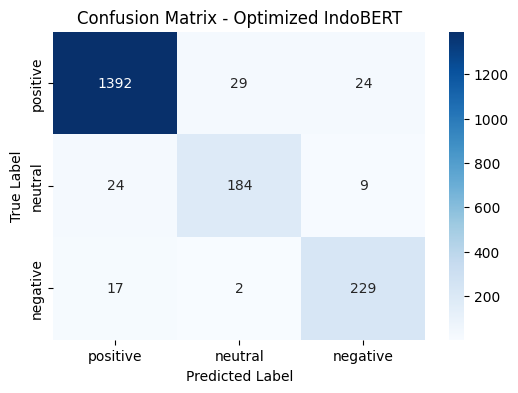

In [11]:
# --- 5. Skenario 3: IndoBERT (Baseline) ---
print("\n\n--- 5. Skenario 3: IndoBERT (Baseline) ---")

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer_bert = AutoTokenizer.from_pretrained(MODEL_NAME)
train_df_hf = pd.DataFrame({'text': train_df['text_clean'].astype(str), 'label': y_train})
test_df_hf = pd.DataFrame({'text': test_df['text_clean'].astype(str), 'label': y_test})
train_dataset_hf = HFDataset.from_pandas(train_df_hf)
test_dataset_hf = HFDataset.from_pandas(test_df_hf)

def tokenize_function(e):
    return tokenizer_bert(e['text'], padding='max_length', truncation=True, max_length=128)

train_tokenized = train_dataset_hf.map(tokenize_function, batched=True)
test_tokenized = test_dataset_hf.map(tokenize_function, batched=True)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

def compute_metrics(p):
    return {"accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}


# Baseline IndoBERT
print("\n--- HASIL MODEL IndoBERT (BASELINE) ---")
training_args_base = TrainingArguments(
    output_dir='./results_base_bert',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    logging_steps=100,
    report_to="none" 
)
trainer_base = CustomTrainer(
    model_init=model_init,
    args=training_args_base,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics
)
trainer_base.train()
predictions_base = trainer_base.predict(test_tokenized)
y_pred_bert_base = np.argmax(predictions_base.predictions, axis=1)
final_results['Baseline IndoBERT'] = classification_report(y_test, y_pred_bert_base, output_dict=True)['weighted avg']
print(f"Akurasi IndoBERT (Baseline): {accuracy_score(y_test, y_pred_bert_base):.4f}")
print("Laporan Klasifikasi IndoBERT (Baseline):")
print(classification_report(y_test, y_pred_bert_base, target_names=label_map.keys()))
plot_confusion_matrix(y_test, y_pred_bert_base, label_map.keys(), "Confusion Matrix - Baseline IndoBERT")


print("\n\n--- 5. Skenario 3: IndoBERT (Optimized) ---")
def objective_indobert(trial):
    training_args = TrainingArguments(
        output_dir='./results_optuna_bert',
        eval_strategy="epoch",
        learning_rate=trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        per_device_train_batch_size=8,
        num_train_epochs=trial.suggest_int("num_train_epochs", 2, 3),
        weight_decay=trial.suggest_float("weight_decay", 0.01, 0.1),
        logging_steps=500,
        disable_tqdm=True,
        save_strategy="no",
        report_to="none"  
    )
    trainer = CustomTrainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=test_tokenized,
        compute_metrics=compute_metrics
    )
    trainer.train()
    return trainer.evaluate()['eval_accuracy']

print("\nMemulai tuning hyperparameter untuk IndoBERT dengan Optuna...")
study_bert = optuna.create_study(direction="maximize")
study_bert.optimize(objective_indobert, n_trials=10) 
best_params_bert = study_bert.best_params

print("\nMelatih model final IndoBERT dengan parameter terbaik...")
final_training_args = TrainingArguments(
    output_dir='./results_final_bert',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_params_bert['learning_rate'],
    per_device_train_batch_size=8,
    num_train_epochs=best_params_bert['num_train_epochs'],
    weight_decay=best_params_bert['weight_decay'],
    logging_steps=100,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none" 
)
final_trainer = CustomTrainer(
    model_init=model_init,
    args=final_training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics
)
final_trainer.train()

predictions = final_trainer.predict(test_tokenized)
y_pred_bert = np.argmax(predictions.predictions, axis=1)
final_results['Optimized IndoBERT'] = classification_report(y_test, y_pred_bert, output_dict=True)['weighted avg']

print("\n--- HASIL MODEL IndoBERT (OPTIMIZED) ---")
print(f"Parameter Terbaik: {best_params_bert}")
print(f"Akurasi IndoBERT: {accuracy_score(y_test, y_pred_bert):.4f}")
print("Laporan Klasifikasi IndoBERT:")
print(classification_report(y_test, y_pred_bert, target_names=label_map.keys()))
plot_confusion_matrix(y_test, y_pred_bert, label_map.keys(), "Confusion Matrix - Optimized IndoBERT")

# --- 6. Perbandingan Akhir Semua Model ---



--- 6. RANGKUMAN AKHIR SEMUA MODEL ---

=== Tabel Perbandingan Performa Akhir ===

                       Accuracy  Precision    Recall  F1-Score
Baseline SVM           0.852356   0.857942  0.852356  0.831546
Baseline Naive Bayes   0.764398   0.761866  0.764398  0.671595
Optimized SVM          0.880628   0.876775  0.880628  0.872785
Optimized Naive Bayes  0.807330   0.796958  0.807330  0.771334
Baseline BiLSTM        0.798429   0.826725  0.798429  0.807922
Optimized BiLSTM       0.865969   0.865086  0.865969  0.865227
Baseline IndoBERT      0.895812   0.901588  0.895812  0.897238
Optimized IndoBERT     0.945026   0.945619  0.945026  0.945220

Plot perbandingan akhir disimpan sebagai 'model_comparison_optimized_final.png'


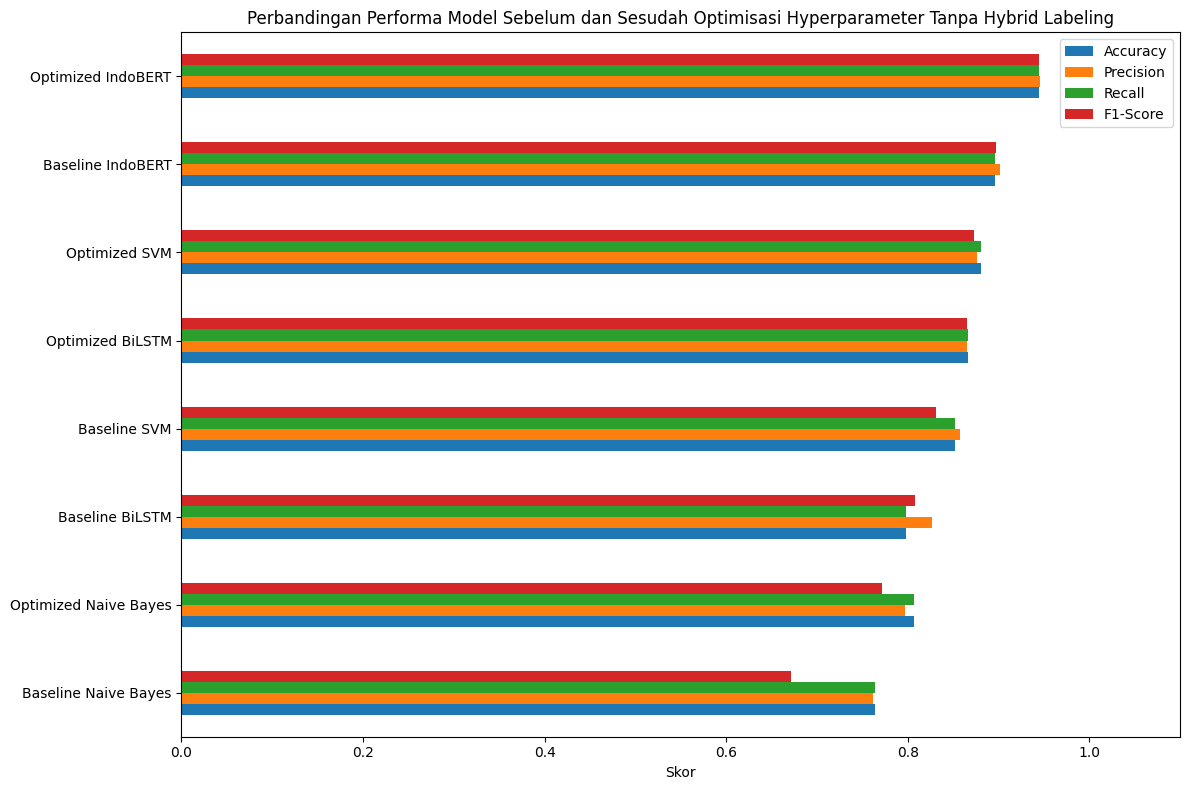

In [12]:
print("\n\n--- 6. RANGKUMAN AKHIR SEMUA MODEL ---")
results_df = pd.DataFrame(final_results).T
results_df.rename(columns={'precision': 'Precision', 'recall': 'Recall', 'f1-score': 'F1-Score'}, inplace=True)
results_df['Accuracy'] = [
    accuracy_score(y_test, y_pred_svm_base),
    accuracy_score(y_test, y_pred_nb_base),
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_bilstm_base),
    accuracy_score(y_test, y_pred_bilstm),
    accuracy_score(y_test, y_pred_bert_base),
    accuracy_score(y_test, y_pred_bert)
]
results_df = results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
print("\n=== Tabel Perbandingan Performa Akhir ===\n")
print(results_df)

# Plot perbandingan
results_df.sort_values('F1-Score').plot(kind='barh', figsize=(12, 8))
plt.title('Perbandingan Performa Model Sebelum dan Sesudah Optimisasi Hyperparameter Dengan Hybrid Labeling')
plt.xlabel('Skor'); plt.xlim(0, 1.1); plt.tight_layout()
plt.savefig('model_comparison_optimized_final.png')
print("\nPlot perbandingan akhir disimpan sebagai 'model_comparison_optimized_final.png'")
plt.show()